# Training and Evaluation

In [19]:
# system imports
import os
from datetime import datetime

# additional imports
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold

# internal imports
from utils import plot_confusion_matrix

## Hyperparameters

In [2]:
hparams = {    
    'dataset': 'data/prepared_data_balanced.csv',
    'epochs': 15,
    'batch_size': 16,
    'lr': 1e-3,
    'features': [
        'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate',
        'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 
        'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20'
    ]
}

## Prepare Data

In [3]:
df_features = pd.read_csv(hparams['dataset'])

X = np.array(df_features[hparams['features']], dtype=np.float32)

encoder = LabelEncoder()
y = encoder.fit_transform(df_features['label'])
print('classes:', encoder.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)

classes: ['covid' 'not_covid']
X_train.shape: (107, 26)
y_train.shape: (107,)


In [29]:
def train_eval_classifier(clf):
    clf.fit(X_train, y_train)

    predictions = clf.predict(X_train)
    accuracy_train = np.sum(predictions == y_train) / len(y_train)
    print("Train Accuracy:", accuracy_train)

    predictions = clf.predict(X_test)
    accuracy_test = np.sum(predictions == y_test) / len(y_test)
    print("Test Accuracy:", accuracy_test)

    plot_confusion_matrix(y_test, predictions, encoder.classes_)

def k_fold_train_eval_classifier(clf):    
    k_folds = 4
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    indices = np.arange(len(y))

    results_train = []
    results_test = []

    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------------------')
    print('|         | Train Accuracy | Test Accuracy |')
    print('--------------------------------------------')

    for fold, (train_ids, test_ids) in enumerate(kfold.split(indices)):
        X_train = X[train_ids]
        y_train = y[train_ids]
        X_test = X[test_ids]
        y_test = y[test_ids]

        # train classifier
        clf.fit(X_train, y_train)

        # evaluate classifier on train dataset
        predictions = clf.predict(X_train)
        train_accuracy = np.sum(predictions == y_train) / len(y_train)
        results_train.append(train_accuracy) 

        # evaluate classifier on test dataset
        predictions = clf.predict(X_test)
        eval_accuracy = np.sum(predictions == y_test) / len(y_test)        
        results_test.append(eval_accuracy) 

        print(f'| Fold {fold}  |       {train_accuracy*100:.2f} % |       {eval_accuracy*100:.2f} % |')

    print('--------------------------------------------')
    print(f'| Average |       {np.mean(results_train)*100:.2f} % |       {np.mean(results_test)*100:.2f} % |')
    
    plot_confusion_matrix(y_test, predictions, encoder.classes_)

## Naive Bayes

K-FOLD CROSS VALIDATION RESULTS FOR 4 FOLDS
--------------------------------------------
|         | Train Accuracy | Test Accuracy |
--------------------------------------------
| Fold 0  |       80.00 % |       70.59 % |
| Fold 1  |       80.00 % |       61.76 % |
| Fold 2  |       74.26 % |       87.88 % |
| Fold 3  |       73.27 % |       81.82 % |
--------------------------------------------
| Average |       76.88 % |       75.51 % |


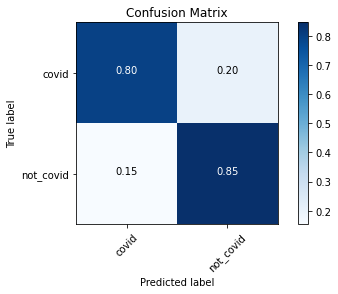

In [30]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
k_fold_train_eval_classifier(clf)

## Support Verctor Machine

K-FOLD CROSS VALIDATION RESULTS FOR 4 FOLDS
--------------------------------------------
|         | Train Accuracy | Test Accuracy |
--------------------------------------------
| Fold 0  |       85.00 % |       73.53 % |
| Fold 1  |       79.00 % |       70.59 % |
| Fold 2  |       80.20 % |       63.64 % |
| Fold 3  |       78.22 % |       93.94 % |
--------------------------------------------
| Average |       80.60 % |       75.42 % |


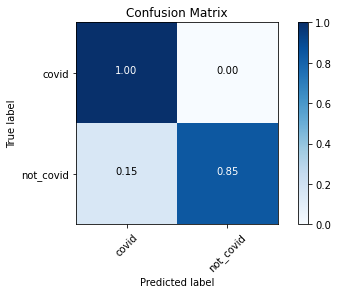

In [42]:
from sklearn import svm

clf = svm.NuSVC(kernel='poly')
k_fold_train_eval_classifier(clf)

## RandomForestClassifier

K-FOLD CROSS VALIDATION RESULTS FOR 4 FOLDS
--------------------------------------------
|         | Train Accuracy | Test Accuracy |
--------------------------------------------
| Fold 0  |       100.00 % |       82.35 % |
| Fold 1  |       100.00 % |       76.47 % |
| Fold 2  |       100.00 % |       90.91 % |
| Fold 3  |       100.00 % |       87.88 % |
--------------------------------------------
| Average |       100.00 % |       84.40 % |


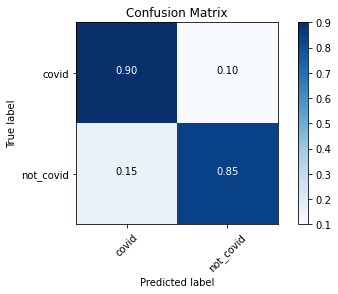

In [31]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=42)
k_fold_train_eval_classifier(clf)